In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:



base_path  = r"C:\Users\maysa\Documents\retail_eda\data"
train_path = os.path.join(base_path, "train.csv")
test_path  = os.path.join(base_path, "test.csv")
stores_path = os.path.join(base_path, "stores.csv")
features_path = os.path.join(base_path, "features.csv")

train_df    = pd.read_csv(train_path)
test_df     = pd.read_csv(test_path)
stores_df   = pd.read_csv(stores_path)
features_df = pd.read_csv(features_path)

print("Shapes:")
print("train   :", train_df.shape)
print("test    :", test_df.shape)
print("stores  :", stores_df.shape)
print("features:", features_df.shape)

for df in [train_df, test_df, features_df]:
    if 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'])
        
tm = (
    train_df
    .merge(stores_df, on='Store', how='left')
    .merge(features_df, on=['Store', 'Date', 'IsHoliday'], how='left')
)

print("\nMerged train shape:", tm.shape)
tm.head()

Shapes:
train   : (421570, 5)
test    : (115064, 4)
stores  : (45, 3)
features: (8190, 12)

Merged train shape: (421570, 16)


,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
1,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106
2,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106
3,1,1,2010-02-26,19403.54,False,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106
4,1,1,2010-03-05,21827.90,False,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106


In [3]:
tm.info()
tm.describe()
tm.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday     421570 non-null  bool          
 5   Type          421570 non-null  object        
 6   Size          421570 non-null  int64         
 7   Temperature   421570 non-null  float64       
 8   Fuel_Price    421570 non-null  float64       
 9   MarkDown1     150681 non-null  float64       
 10  MarkDown2     111248 non-null  float64       
 11  MarkDown3     137091 non-null  float64       
 12  MarkDown4     134967 non-null  float64       
 13  MarkDown5     151432 non-null  float64       
 14  CPI           421570 non-null  float64       
 15  Unemployment  421

Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday            0
Type                 0
Size                 0
Temperature          0
Fuel_Price           0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
CPI                  0
Unemployment         0
dtype: int64

In [4]:
tm['Year'] = tm['Date'].dt.year
tm['Month'] = tm['Date'].dt.month
tm['Week'] = tm['Date'].dt.isocalendar().week
tm['DayOfWeek'] = tm['Date'].dt.dayofweek


In [5]:
plt.style.use("seaborn-v0_8")

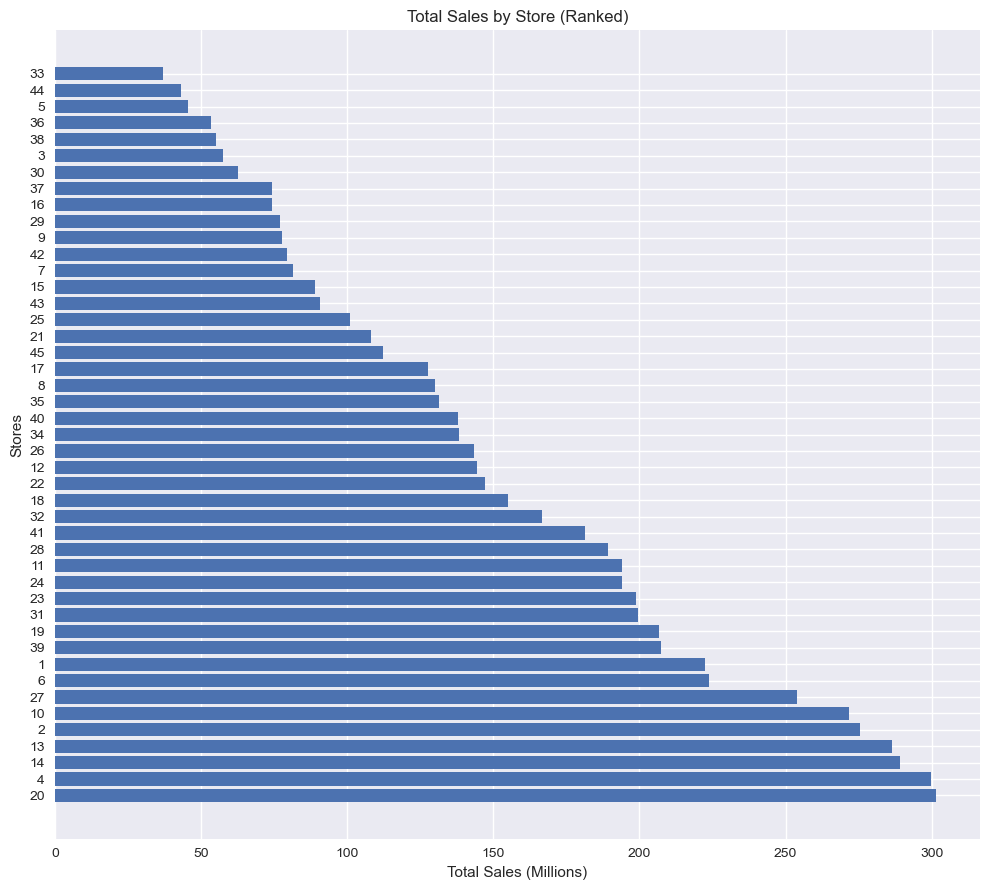

In [6]:
total = tm['Weekly_Sales'].groupby(tm['Store']).sum().sort_values(ascending=False)
total_mil = total / 1000000 #scaled to millions

fig, ax = plt.subplots(figsize=(10,9))
ax.barh(total_mil.index.astype(str), total_mil.values)
ax.set_title("Total Sales by Store (Ranked)")
ax.set_xlabel("Total Sales (Millions)")
ax.set_ylabel("Stores")
ax.tick_params(axis='y', rotation=0)
plt.tight_layout()


Text(0, 0.5, 'Store')

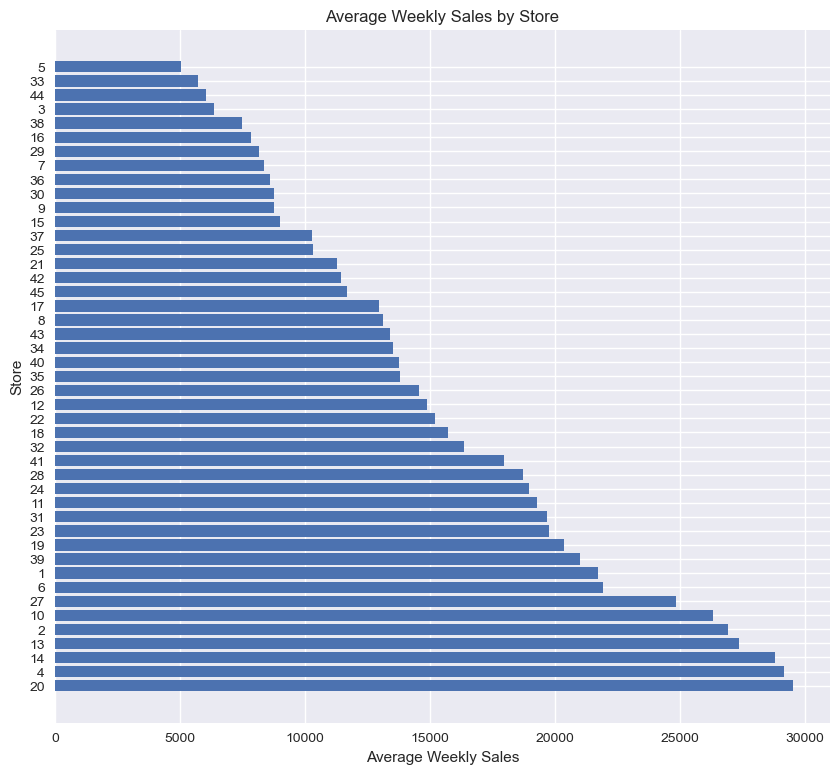

In [7]:
avg_weekly = tm.groupby('Store')['Weekly_Sales'].mean().sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(10,9))
ax.barh(avg_weekly.index.astype(str), avg_weekly.values)
ax.set_xlabel('Average Weekly Sales')
ax.set_title('Average Weekly Sales by Store')
ax.set_ylabel('Store')


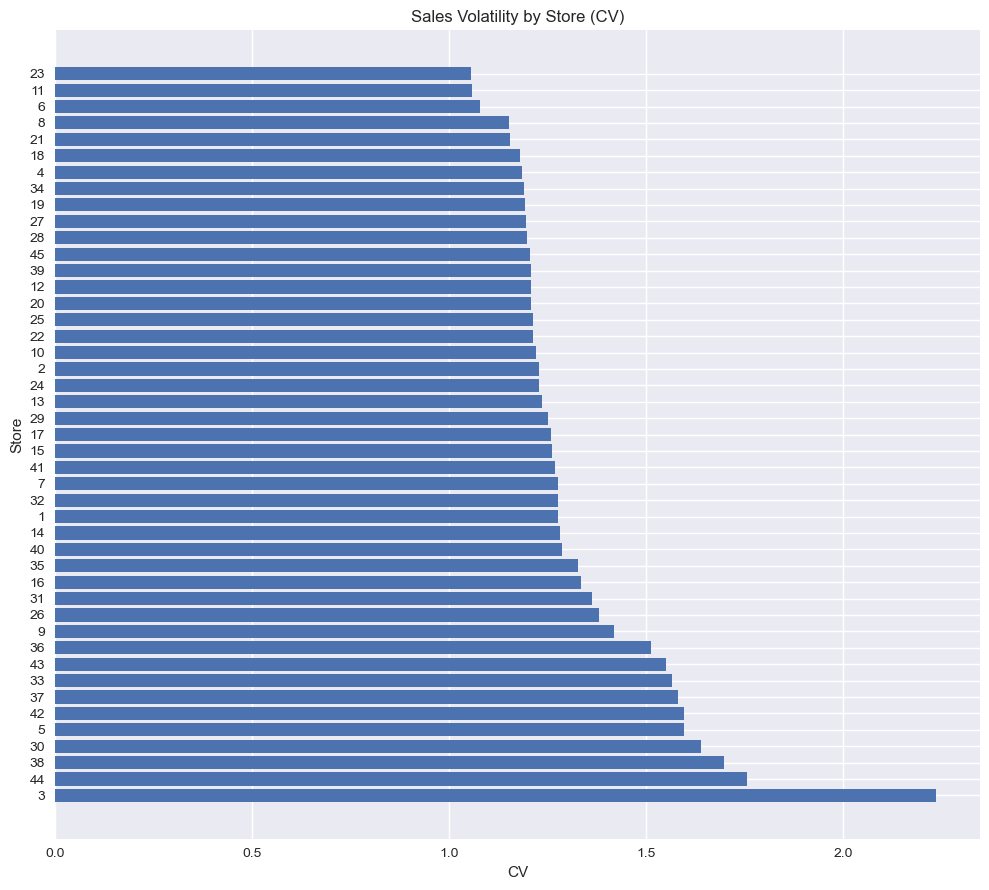

In [8]:
cv_df = (tm.groupby('Store')['Weekly_Sales'].agg(mean='mean', std='std'))
cv_df['CV'] = cv_df['std'] / cv_df['mean']
cv_sorted = cv_df['CV'].sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(10,9))
ax.barh(cv_sorted.index.astype(str), cv_sorted.values)
ax.set_title('Sales Volatility by Store (CV)')
ax.set_xlabel('CV')
ax.set_ylabel('Store')
plt.tight_layout()



Text(0.5, 1.0, 'Store Leaderboard: Average Weekly Sales (4 Weeks)')

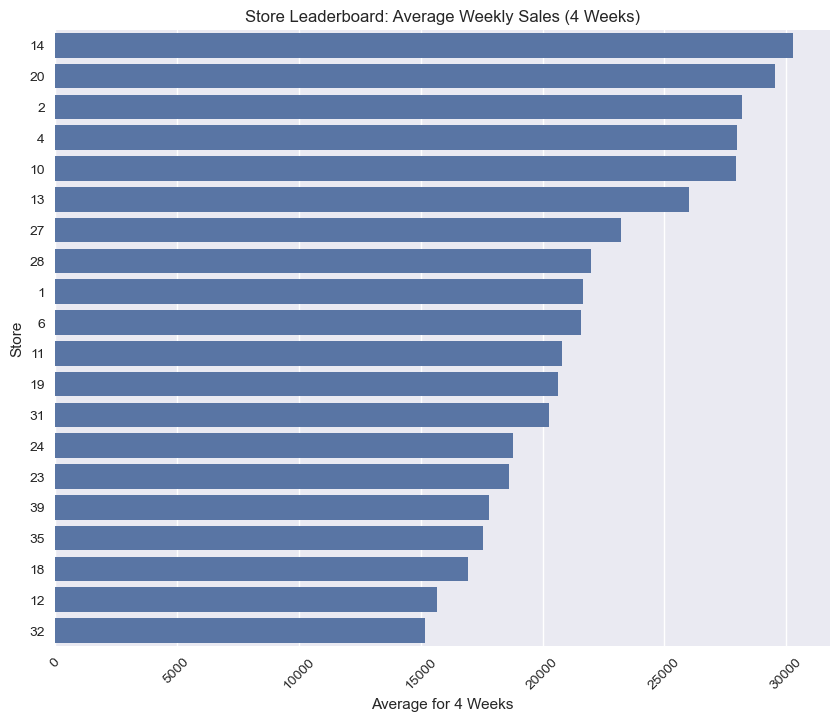

In [9]:
df = tm[["Store", "Date", "Weekly_Sales"]]

four_weekstat = df.loc[(df["Date"] >= "2010-02-05") &
                       (df["Date"] <= "2010-03-05")]
final = four_weekstat.groupby( 'Store', as_index=False)['Weekly_Sales'].mean().rename(
    columns={'Weekly_Sales':'Mean_4w'}).sort_values('Mean_4w', ascending=False).head(20)
plt.figure(figsize=(10,8))
g = sns.barplot(data=final, x='Mean_4w', y=final['Store'].astype(str))
plt.tick_params(axis='x', rotation=45)
g.set(xlabel="Average for 4 Weeks",
      ylabel="Store")
g.set_title("Store Leaderboard: Average Weekly Sales (4 Weeks)")




Text(0.5, 1.02, 'YoY Sales Growth by Store (%), 2011 vs 2010')

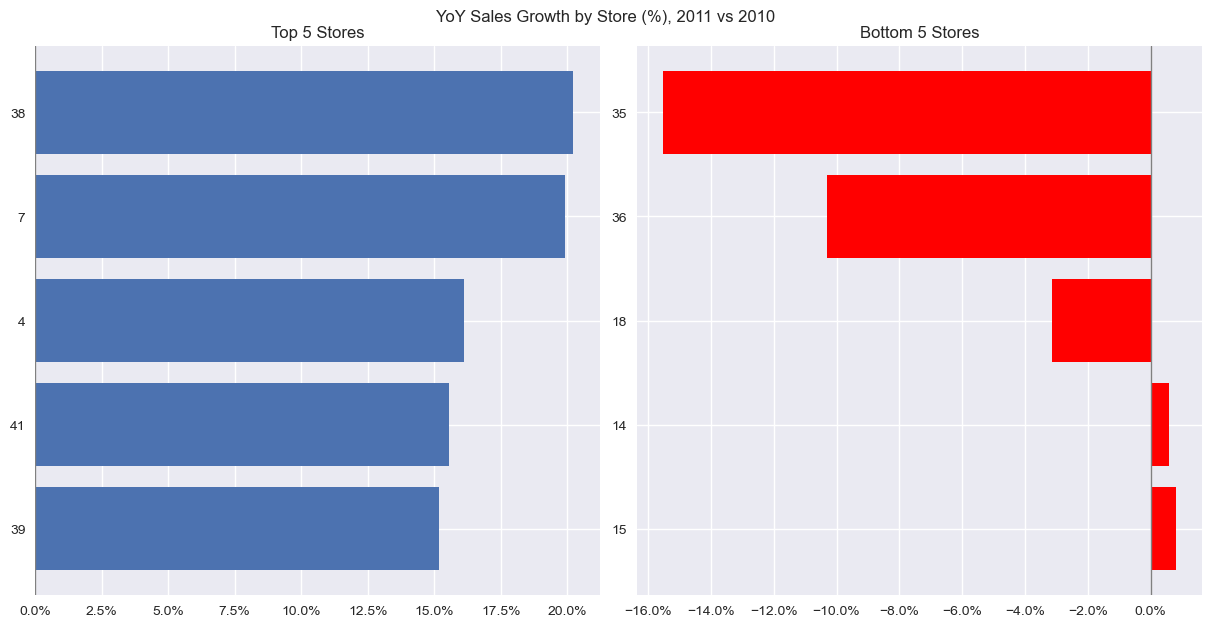

In [10]:
from matplotlib.ticker import PercentFormatter
dx = tm[["Store", "Date", "Weekly_Sales"]]

prev_year = dx.loc[(dx["Date"] >= "2010-01-01") &
                    (dx["Date"] <= "2010-12-31")]
prev_year_sum = prev_year.groupby('Store',as_index=False)['Weekly_Sales'].sum()

current_year = dx.loc[(dx["Date"] >= "2011-01-01") &
                    (dx["Date"] <= "2011-12-31")]
current_year_sum = current_year.groupby('Store', as_index=False)['Weekly_Sales'].sum()

current_year_sum['Yoy'] = (current_year_sum['Weekly_Sales'] - prev_year_sum['Weekly_Sales']) / prev_year_sum['Weekly_Sales']
current_year_sum1 = current_year_sum.sort_values(by='Yoy', ascending=False).head(5)
current_year_sum2 = current_year_sum.sort_values(by='Yoy', ascending=True).head(5)

fig, ax = plt.subplots(1, 2, figsize=(12,6), constrained_layout=True)
ax[0].cla()
ax[0].barh(current_year_sum1['Store'].astype(str), current_year_sum1['Yoy'])
ax[1].cla()
ax[1].barh(current_year_sum2['Store'].astype(str), current_year_sum2['Yoy'], color='r')

ax[0].set_title("Top 5 Stores")
ax[1].set_title("Bottom 5 Stores")

ax[0].axvline(0, color='gray', linewidth=1)
ax[1].axvline(0, color='gray', linewidth=1)

ax[0].xaxis.set_major_formatter(PercentFormatter(1.0))
ax[1].xaxis.set_major_formatter(PercentFormatter(1.0))

ax[1].invert_yaxis()
ax[0].invert_yaxis()

fig.suptitle('YoY Sales Growth by Store (%), 2011 vs 2010', y=1.02)

<Axes: xlabel='mean', ylabel='std'>

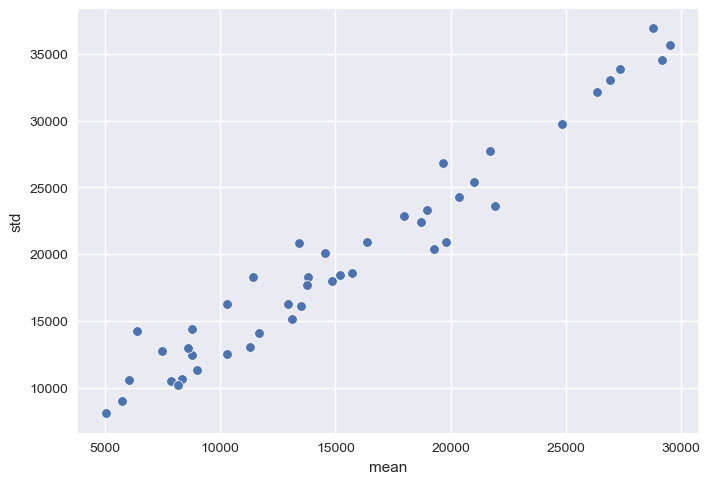

In [11]:
g = tm.groupby('Store')['Weekly_Sales'].agg(mean='mean', std='std').reset_index()
sns.scatterplot(data=g, x='mean', y='std', )

Text(94.22222222222221, 0.5, 'Store')

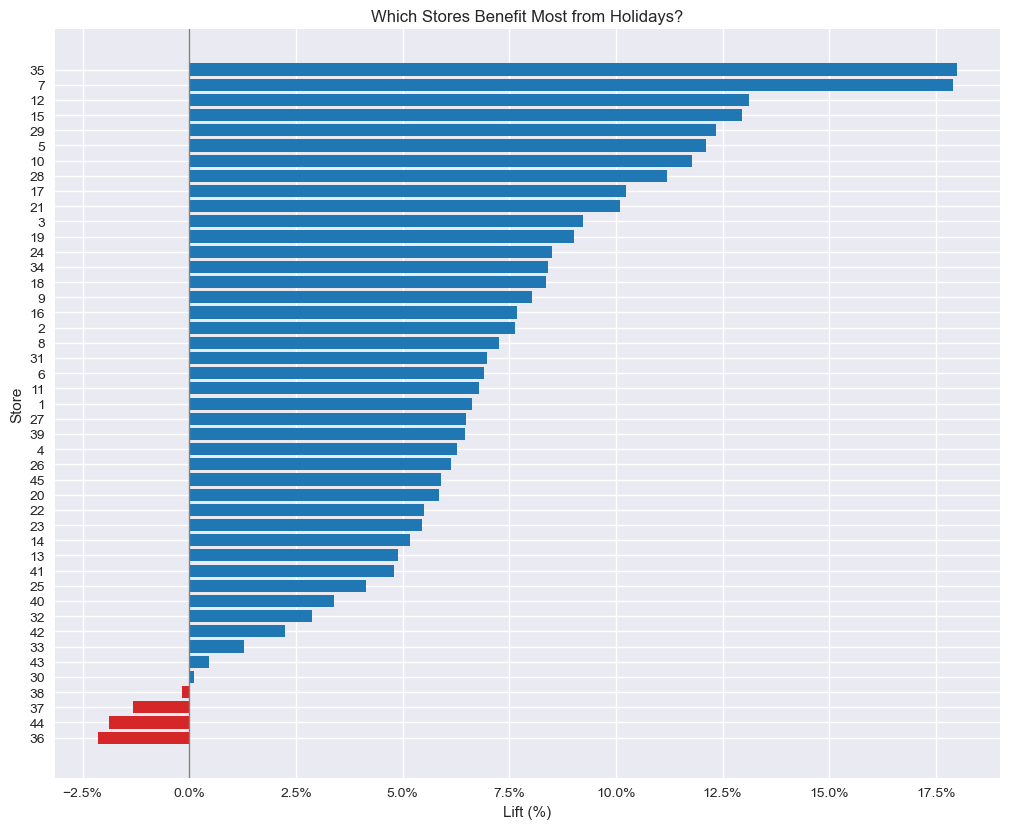

In [39]:
from matplotlib.ticker import PercentFormatter

df = tm[['Store', 'Weekly_Sales', 'IsHoliday']]

df_t = df[df['IsHoliday'] == True] 

df_f = df[df['IsHoliday'] == False] 
df_t_mean = df_t.groupby('Store')['Weekly_Sales'].mean().reset_index()
df_f_mean = df_f.groupby('Store')['Weekly_Sales'].mean().reset_index()

df_t_mean.columns= ['Store', 'HolidayMean']
df_f_mean.columns= ['Store', 'NonHolidayMean']

store_stats = df_t_mean.merge(df_f_mean, on='Store')
store_stats['Lift%'] = (store_stats['HolidayMean'] - store_stats['NonHolidayMean']) / store_stats['NonHolidayMean'] * 100
store_stats = store_stats.sort_values(by='Lift%', ascending = True)

fig, ax= plt.subplots(figsize=(10,8))
colors = np.where(store_stats['Lift%'] >= 0, 'tab:blue', 'tab:red')
ax.barh(store_stats['Store'].astype(str),
        store_stats['Lift%'],
        color=colors)
ax.axvline(0, 
           color='gray',
           linewidth=1)
ax.xaxis.set_major_formatter(PercentFormatter(100))
plt.tight_layout()
plt.title('Which Stores Benefit Most from Holidays?')
ax.set_xlabel('Lift (%)')
ax.set_ylabel('Store')




Text(0.5, 1.0, 'Bars = Total Sales (Millions), blue bars account for ~80% cumulative')

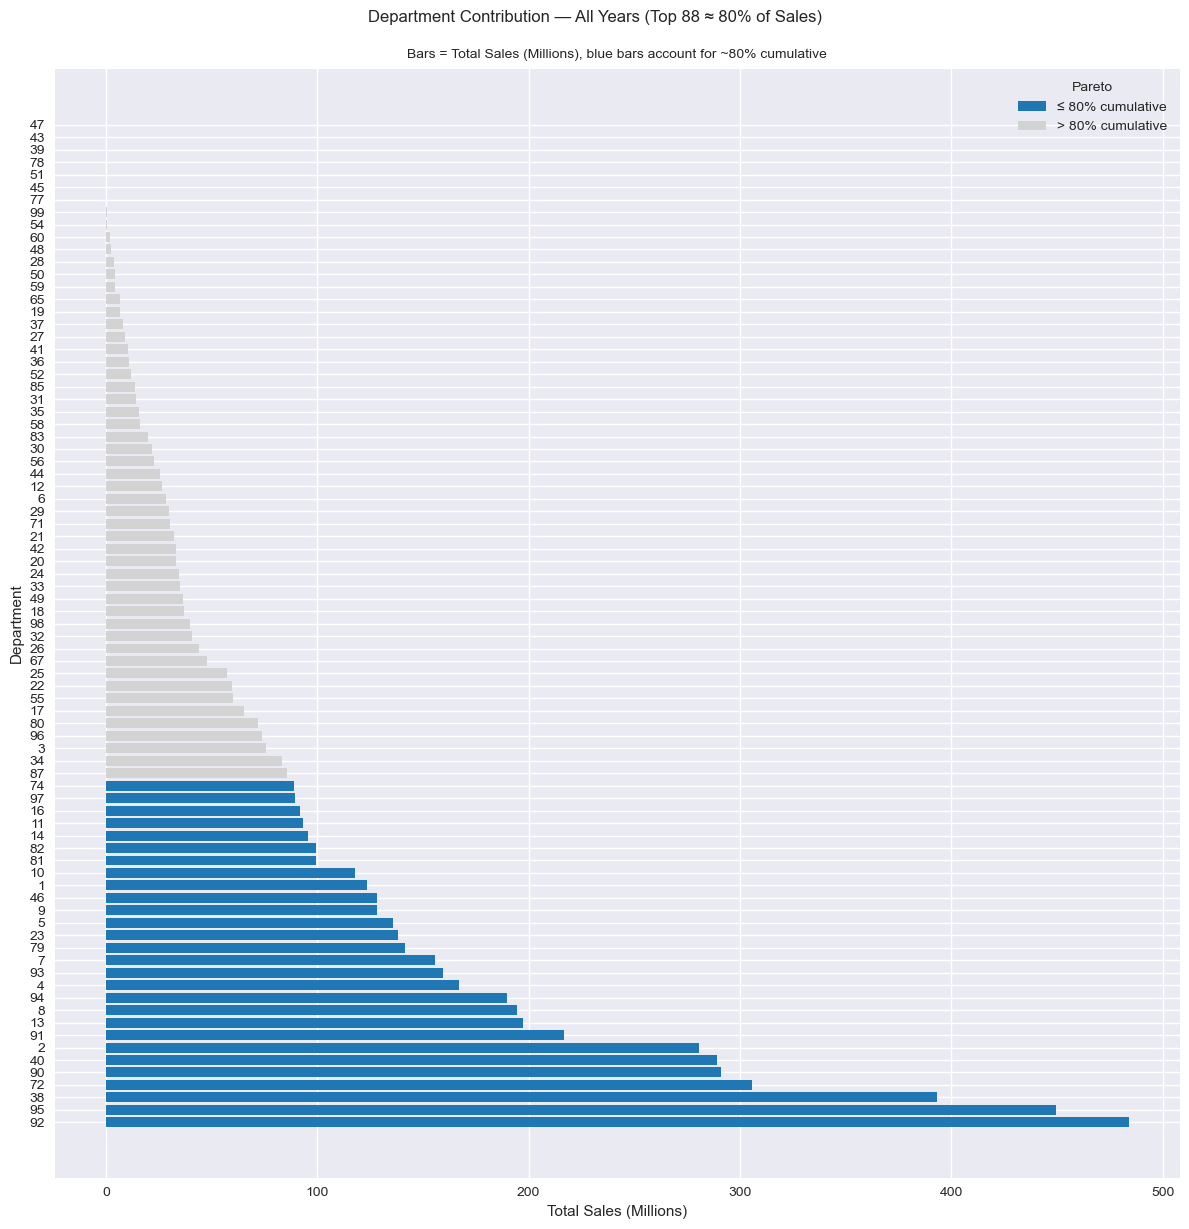

In [47]:
from matplotlib.patches import Patch

df = tm[['Dept', 'Weekly_Sales']]
df = df.groupby('Dept')['Weekly_Sales'].sum().sort_values(ascending=False)
df = df / 1000000 

cum = df.cumsum() / df.sum()
cut_idx = int((cum >= 0.80).idxmax())

colors = np.where(cum.values <= 0.80, 'tab:blue', 'lightgray')
fig, ax = plt.subplots(figsize=(12,12))
ax.barh(df.index.astype(str), df.values, color=colors)
ax.set_xlabel('Total Sales (Millions)')
ax.set_ylabel('Department')

fig.suptitle(f'Department Contribution — All Years (Top {cut_idx+1} ≈ 80% of Sales)',
             y=1.02)
ax.set_title('Bars = Total Sales (Millions), blue bars account for ~80% cumulative', 
             fontsize=10,
             pad=8)

legend_handles = [
    Patch(facecolor='tab:blue',
          label='≤ 80% cumulative'),
    Patch(facecolor='lightgray', 
          label='> 80% cumulative'),
]
ax.legend(handles=legend_handles,
          loc='upper right', 
          frameon=False, 
          title='Pareto')
plt.tight_layout()



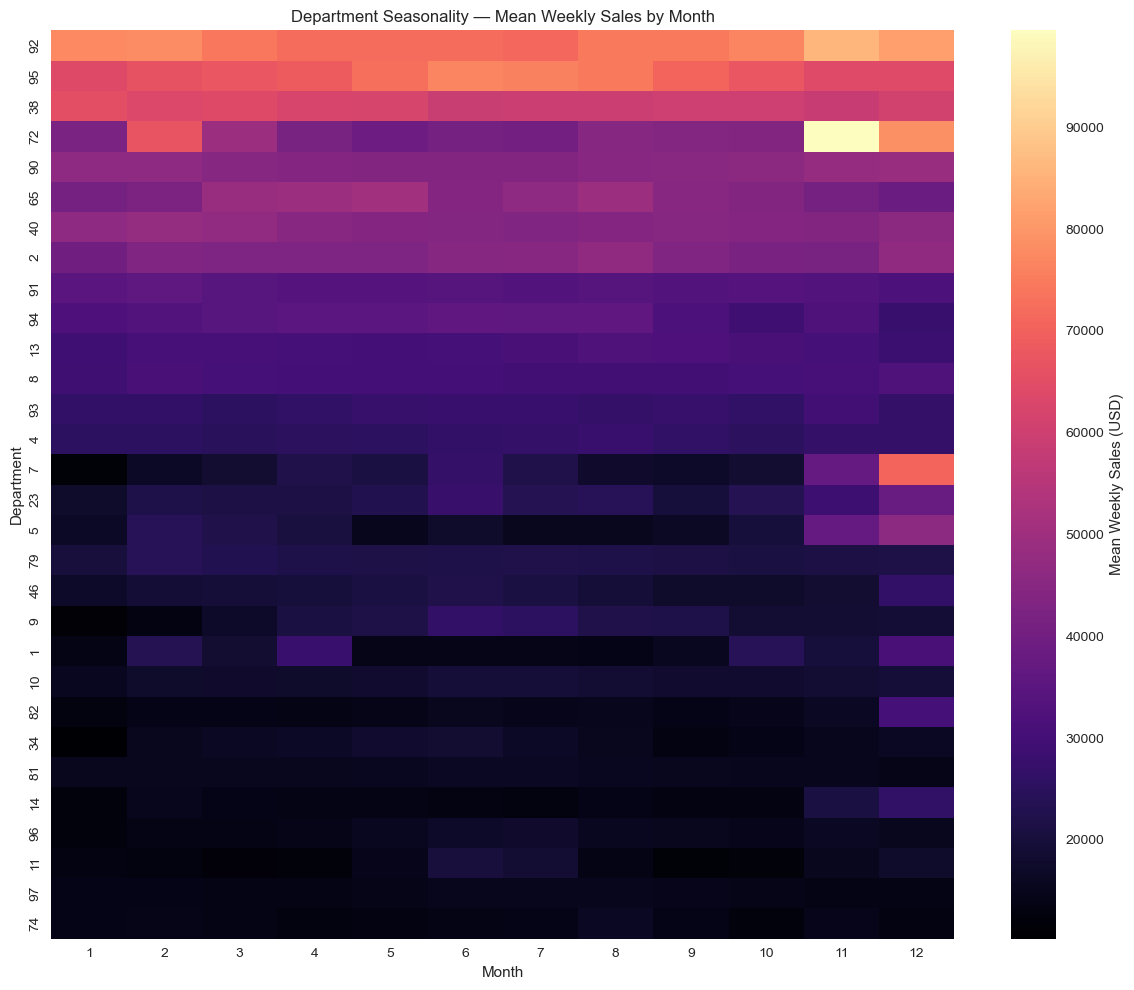

In [113]:
df = tm[['Dept', 'Month', 'Weekly_Sales']]
df = df.groupby(['Dept', 'Month'])['Weekly_Sales'].mean().unstack(fill_value=0)

df_sorted = (df.assign(mean=df.mean(axis=1)).sort_values('mean', ascending=False).drop(columns='mean').head(30))
plt.figure(figsize=(12, 10))
sns.heatmap(df_sorted,
            cmap='magma',
            cbar_kws={'label': 'Mean Weekly Sales (USD)'})
plt.title('Department Seasonality — Mean Weekly Sales by Month')
plt.xlabel('Month')
plt.ylabel('Department')
plt.tight_layout()
plt.show()

[Text(0.5, 0, 'Size'), Text(0, 0.5, 'Average Weekly Sales')]

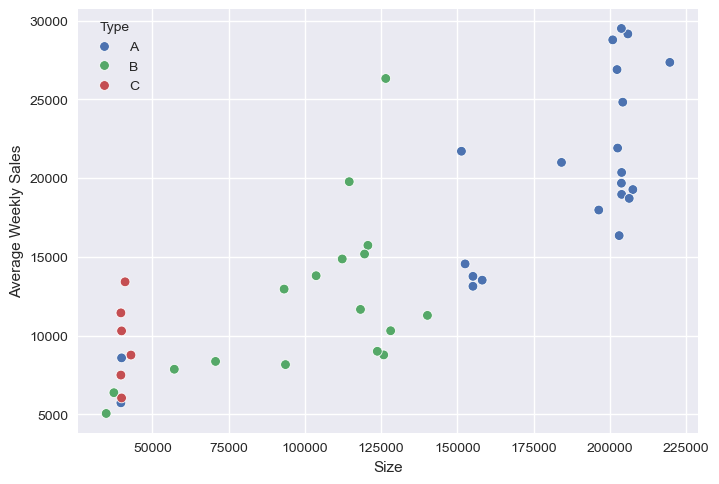

In [225]:
df_sorted = tm.groupby('Store', as_index=False)[['Weekly_Sales']].mean().rename(columns={'Weekly_Sales':'AvgwWeklySales'})
df_final = df_sorted.merge(tm[['Store','Size','Type']], on='Store', how='left')
df_distinct= df_final.drop_duplicates()

g = sns.scatterplot(data=df_distinct,
                    x='Size', 
                    y='AvgwWeklySales', 
                    hue='Type')

g.set(xlabel='Size',
      ylabel='Average Weekly Sales')


    Store          mean        cv Type
22     23  19776.180881  1.056679    B
10     11  19276.762751  1.057849    A
5       6  21913.243624  1.078500    A
17     18  15733.313136  1.179431    B
3       4  29161.210415  1.185948    A
    Store         mean        cv Type
2       3  6373.033983  2.236146    B
43     44  6038.929814  1.756846    C
37     38  7492.478460  1.699485    C
29     30  8764.237719  1.638969    C
4       5  5053.415813  1.596588    B


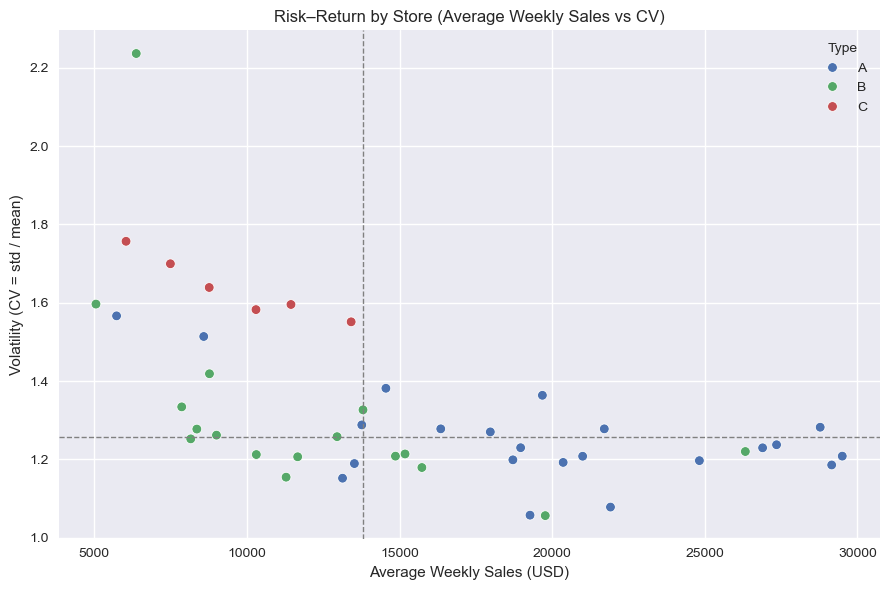

In [229]:
df1 = tm.groupby(['Store', 'Type'], as_index=False)['Weekly_Sales'].agg(['mean','std'])
df1['cv'] = df1['std'] / df1['mean']

mean_md, cv_md = df1['mean'].median(), df1['cv'].median()

plt.figure(figsize=(9,6))
sns.scatterplot(x='mean', y='cv', data=df1, hue='Type')
plt.axvline(xm, color='gray', linestyle='--', linewidth=1)
plt.axhline(ym, color='gray', linestyle='--', linewidth=1)
plt.title('Risk–Return by Store (Average Weekly Sales vs CV)')
plt.xlabel('Average Weekly Sales (USD)')
plt.ylabel('Volatility (CV = std / mean)')
plt.tight_layout()
df1.head()

df_top = df1[['Store', 'mean', 'cv', 'Type']]
df_top_5 = df_top[(df_top['mean'] >= mean_md) & (df_top['cv'] <= cv_md)].sort_values(['cv','mean']).head(5)
df_bottom_5 = df_top.sort_values('cv', ascending=False).head(5)

print(df_top_5)
print(df_bottom_5)
